In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os

sns.set(style="whitegrid")

In [63]:
student_df = pd.read_csv("education_dataset/Student_Records.csv")
school_df = pd.read_csv("education_dataset/School_Info.csv")

In [64]:
# Fill missing attendance rate with median
student_df["Attendance_Rate"] = student_df["Attendance_Rate"].fillna(student_df["Attendance_Rate"].median())

# Fill missing library status with mode
school_df["Library_Status"] = school_df["Library_Status"].fillna(school_df["Library_Status"].mode()[0])

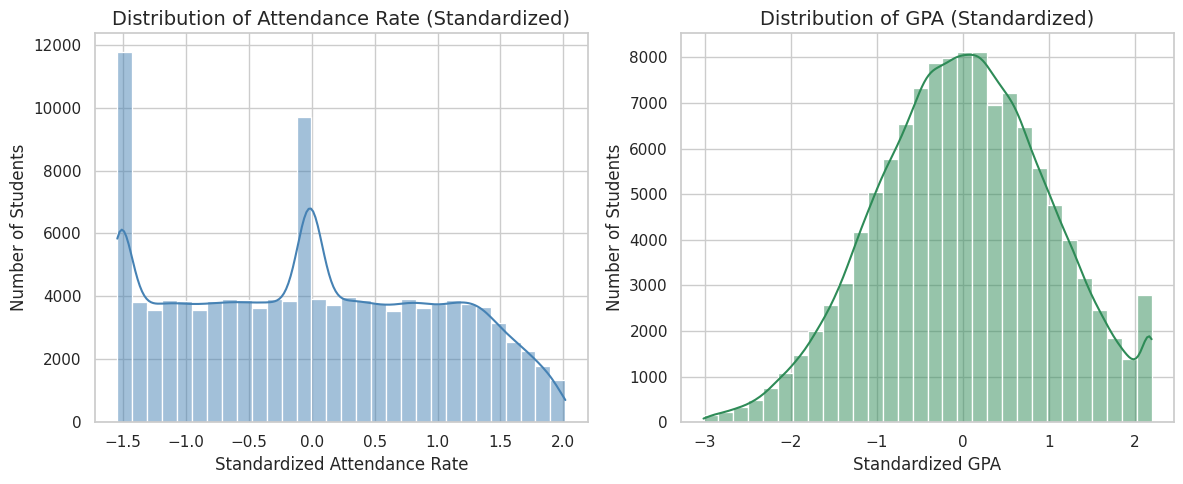

In [78]:
plt.figure(figsize=(12, 5))

# Attendance Rate
plt.subplot(1, 2, 1)
sns.histplot(df["Attendance_Rate"], bins=30, kde=True, color="steelblue")
plt.title("Distribution of Attendance Rate (Standardized)", fontsize=14)
plt.xlabel("Standardized Attendance Rate")
plt.ylabel("Number of Students")

# GPA
plt.subplot(1, 2, 2)
sns.histplot(df["Previous_Year_GPA"], bins=30, kde=True, color="seagreen")
plt.title("Distribution of GPA (Standardized)", fontsize=14)
plt.xlabel("Standardized GPA")
plt.ylabel("Number of Students")

plt.tight_layout()
plt.show()

In [65]:
z_scores = np.abs(stats.zscore(student_df[["Attendance_Rate", "Previous_Year_GPA"]]))
outlier_mask = (z_scores > 3).any(axis=1)
print(f"Outliers removed: {outlier_mask.sum()}")
student_df = student_df[~outlier_mask]

Outliers removed: 202


In [66]:
df = pd.merge(student_df, school_df, on="School_ID", how="left")

In [67]:
categorical_cols = ["Gender", "Socioeconomic_Status", "District", "Location_Type", 
                    "Electricity_Access", "Internet_Access", "Library_Status"]
encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
for col in categorical_cols:
    df[col] = encoders[col].transform(df[col])

In [68]:
scaler = StandardScaler()
num_cols = ["Grade", "Attendance_Rate", "Previous_Year_GPA", "Infrastructure_Score"]
df[num_cols] = scaler.fit_transform(df[num_cols])

In [61]:
# Merge school info into students for modeling
merged_df = pd.merge(student_df_clean, school_df, on="School_ID", how="left")

# Check shape
merged_df.head()

,Student_ID,School_ID,Grade,Gender,Socioeconomic_Status,Attendance_Rate,Previous_Year_GPA,Dropout_Status,District,Location_Type,Infrastructure_Score,Electricity_Access,Internet_Access,Library_Status
0,STU00001,SCH0470,1,F,Medium,0.669195,1.187419,N,Dhading,Rural,-0.936648,N,N,Y
1,STU00002,SCH0720,6,F,High,1.944514,-0.374740,N,Sindhupalchok,Urban,0.855465,Y,Y,Y
2,STU00003,SCH0682,7,F,Low,-0.563376,-0.622933,Y,Sindhupalchok,Rural,-1.384676,N,N,N
3,STU00004,SCH0438,6,M,Low,1.944514,1.669206,N,Sindhupalchok,Urban,-0.309408,Y,Y,N
4,STU00005,SCH0171,4,M,Medium,1.274794,2.194793,N,Sindhupalchok,Urban,0.138620,Y,Y,N


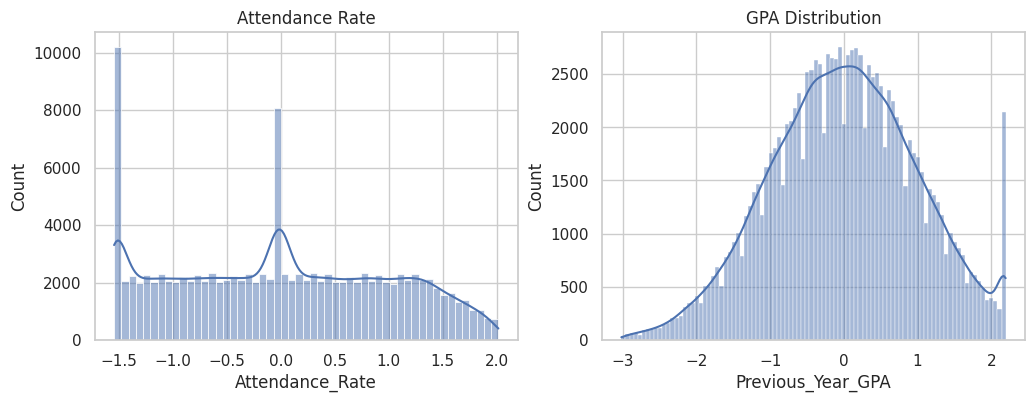

In [69]:
# GPA & Attendance Distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df["Attendance_Rate"], ax=axes[0], kde=True)
axes[0].set_title("Attendance Rate")
sns.histplot(df["Previous_Year_GPA"], ax=axes[1], kde=True)
axes[1].set_title("GPA Distribution")
plt.show()

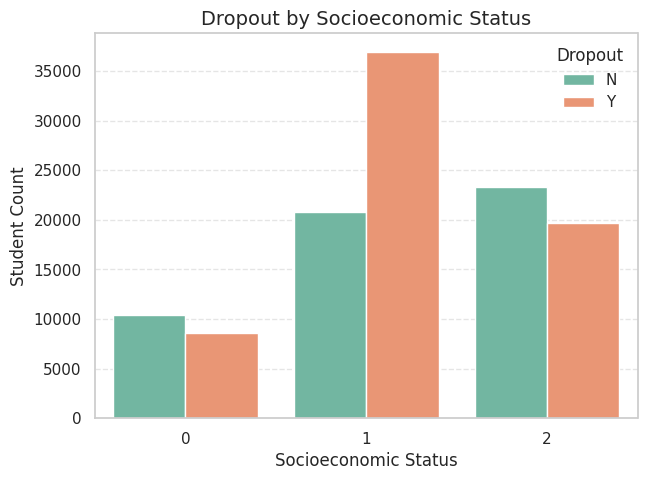

In [79]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="Socioeconomic_Status", hue="Dropout_Status", palette="Set2")
plt.title("Dropout by Socioeconomic Status", fontsize=14)
plt.xlabel("Socioeconomic Status")
plt.ylabel("Student Count")
plt.legend(title="Dropout")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

/tmp/ipykernel_42693/2850853036.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dropout_Status", y="Previous_Year_GPA", data=df, palette="coolwarm")


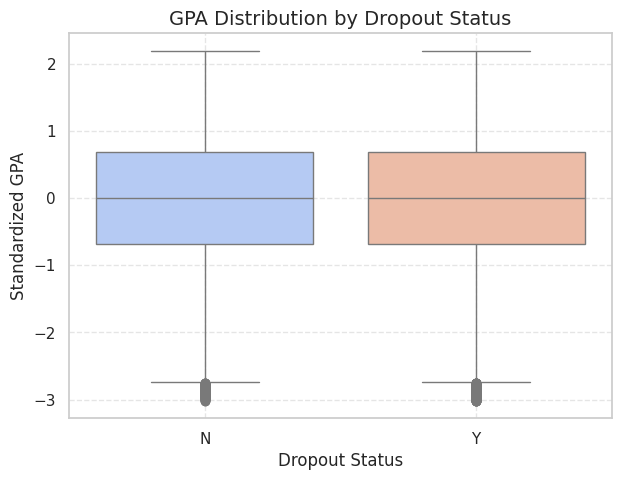

In [80]:
plt.figure(figsize=(7, 5))
sns.boxplot(x="Dropout_Status", y="Previous_Year_GPA", data=df, palette="coolwarm")
plt.title("GPA Distribution by Dropout Status", fontsize=14)
plt.xlabel("Dropout Status")
plt.ylabel("Standardized GPA")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


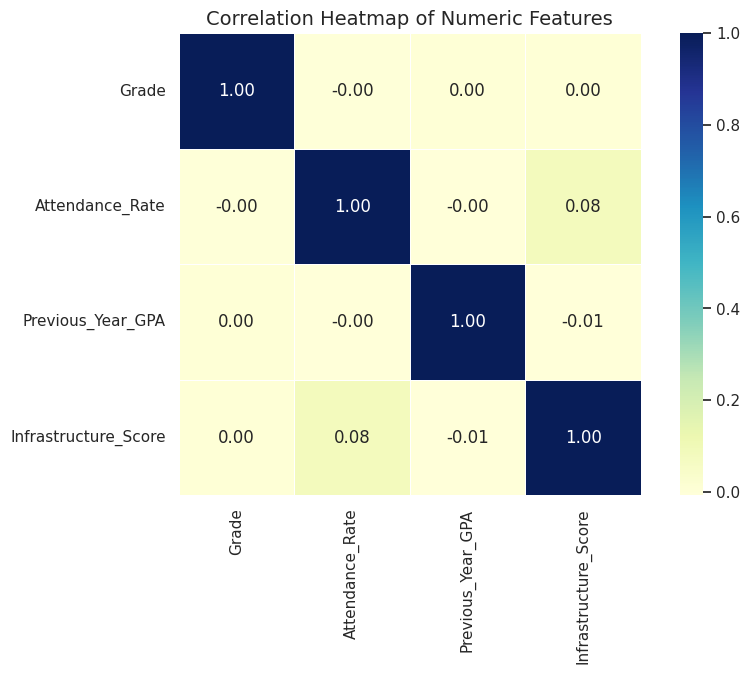

In [81]:
plt.figure(figsize=(10, 6))
numeric_cols = df[["Grade", "Attendance_Rate", "Previous_Year_GPA", "Infrastructure_Score"]]
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

In [72]:
features = ["Grade", "Gender", "Socioeconomic_Status", "Attendance_Rate", "Previous_Year_GPA",
            "District", "Location_Type", "Infrastructure_Score", "Electricity_Access", 
            "Internet_Access", "Library_Status"]
target = "Dropout_Status"

X = df[features].values
y = df[target].map({"Y": 1, "N": 0}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [73]:
class DropoutDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(DropoutDataset(X_train, y_train), batch_size=256, shuffle=True)
test_loader = DataLoader(DropoutDataset(X_test, y_test), batch_size=256)

In [74]:
class DropoutNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DropoutNet(input_size=X.shape[1]).to(device)

In [75]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_loss = np.inf
patience = 3
counter = 0
train_losses = []

for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_dropout_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1: Loss=0.3479
Epoch 2: Loss=0.2559
Epoch 3: Loss=0.2414
Epoch 4: Loss=0.2348
Epoch 5: Loss=0.2310
Epoch 6: Loss=0.2302
Epoch 7: Loss=0.2297
Epoch 8: Loss=0.2295
Epoch 9: Loss=0.2262
Epoch 10: Loss=0.2248
Epoch 11: Loss=0.2249
Epoch 12: Loss=0.2262
Epoch 13: Loss=0.2238
Epoch 14: Loss=0.2242
Epoch 15: Loss=0.2242
Epoch 16: Loss=0.2221
Epoch 17: Loss=0.2237
Epoch 18: Loss=0.2212
Epoch 19: Loss=0.2178
Epoch 20: Loss=0.2209
Epoch 21: Loss=0.2215
Epoch 22: Loss=0.2189
Early stopping triggered.


In [76]:
model.load_state_dict(torch.load("best_dropout_model.pt"))
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb).cpu().numpy()
        y_pred.extend((out > 0.5).astype(int).flatten())
        y_true.extend(yb.numpy().flatten())

print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


/tmp/ipykernel_42693/3274149636.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_dropout_model.pt"))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.99      0.90     10911
         1.0       0.99      0.82      0.90     13049

    accuracy                           0.90     23960
   macro avg       0.90      0.90      0.90     23960
weighted avg       0.91      0.90      0.90     23960

Confusion Matrix:
 [[10753   158]
 [ 2338 10711]]


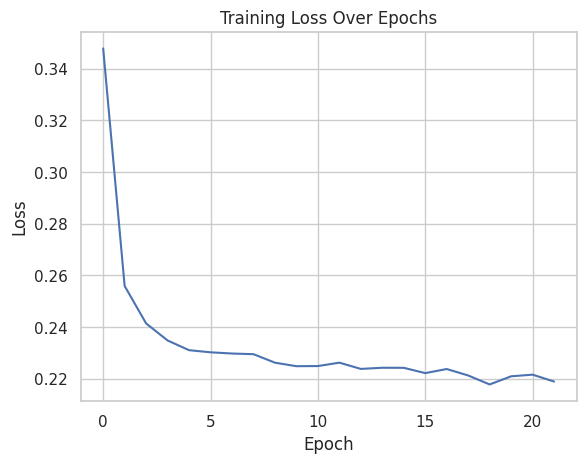

In [77]:
plt.plot(train_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()